# LAB ASSIGNMENT 6 IMAGE SIGNAL PROCESSING

## MANSI KAKKAR
## EE21S063

**IMPORTING LIBRARIES**

* scipy.io : for reading the images in .mat format

* numpy : for finding size of image

* matplotlib.pyplot : for plotting the function

* matplotlib.cm : for 3d colormap

In [1]:
import numpy as np
import scipy.io
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [2]:
!ls

Lab_06.pdf           Untitled.ipynb
PA(6)_EE21S063.ipynb stack.mat


**READING IMAGES**

In [3]:
mat = scipy.io.loadmat('stack.mat')
n_frames = int(mat['numframes'])
frames = {}
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Fri Feb 05 14:40:11 2010',
 '__version__': '1.0',
 '__globals__': [],
 'numframes': array([[100]], dtype=uint8),
 'frame001': array([[56, 56, 57, ..., 52, 51, 51],
        [56, 56, 57, ..., 52, 51, 51],
        [57, 57, 58, ..., 53, 52, 52],
        ...,
        [52, 52, 53, ..., 58, 57, 57],
        [51, 51, 52, ..., 58, 57, 57],
        [51, 51, 52, ..., 57, 57, 56]], dtype=uint8),
 'frame002': array([[55, 55, 56, ..., 51, 50, 50],
        [55, 56, 57, ..., 51, 51, 50],
        [56, 57, 58, ..., 52, 51, 51],
        ...,
        [52, 52, 52, ..., 58, 57, 57],
        [51, 51, 52, ..., 57, 57, 56],
        [51, 51, 51, ..., 57, 56, 56]], dtype=uint8),
 'frame003': array([[55, 55, 56, ..., 51, 50, 50],
        [55, 56, 57, ..., 51, 50, 50],
        [56, 57, 58, ..., 52, 51, 51],
        ...,
        [52, 52, 52, ..., 59, 58, 57],
        [51, 51, 52, ..., 58, 57, 57],
        [51, 51, 51, ..., 58, 57, 57]], dtype=uint8)

**PRINTING NUMBER OF FRAMES**

In [4]:
n_frames

100

**STORING IMAGES TO IMAGE DICTIONARY**

In [5]:
for key in mat.keys():
    if key[:5] == 'frame':
        frames[int(key[5:])] = mat[key]
#del_d as given in the problem
del_d = 50.50

**DEFINING DOUBLE DERIVATIVE OPERATORS**

Define the partial derivative operators

In [6]:
lx = np.array([[0,  0, 0],
               [1, -2, 1],
               [0,  0, 0]])
ly = np.array([[0,  1, 0],
               [0, -2, 1],
               [0,  1, 0]])

**ZERO PADDED IMAGE**



In [7]:
#Zero Padding the Image
def zero_padded_image(source, padding):
    #padding size
    [x,y] = np.shape(source)
    padded = np.zeros((x+2*padding,y+2*padding))
    #New Image
    padded[padding:-padding,padding:-padding] = source
    return padded

**DEFINING WINDOW SIZE**

Given $q = 0, 1, 2$ ; defining the neighbourhood

Calculating the kernel to obtain the sum modified Laplacian from the modified Laplacian values.

For given $q$ matrix size is chosen to be $(2q+1) \times (2q+1)$

for $q = 0$ $--->$ at that point

for $q = 1$ $--->$ 3 X 3 neighbourhood

for $q = 2$ $--->$ 5 X 5 neighbourhood

In [8]:
#Window Size
def window_size(q):
    w = 2*q+1
    return np.ones((w,w))

**MODIFIED LAPLACIAN**

Defining modified laplacian operator,

$ML = |f_{xx}| + |f_{yy}|$ ;where $f_{xx}$ and $f_{yy}$ are discrete 2D double derivatives of the image.

In [9]:
#Modified Laplacian
def mod_laplacian(source, padding):
    #padding the image with respect to the fact whether padding is > zero or not
    if padding!=0:
        padded_image = zero_padded_image(source, padding)
    else:
        padded_image = source
    #convolving image and double derivative operator
    f_xx = Convolution_2d(padded_image, lx)
    f_yy = Convolution_2d(padded_image, ly)
    #returning ML as defined above
    return np.abs(f_xx)+np.abs(f_yy)


**SUM MODIFIED LAPLACIAN**

Defining Sum Modified Laplacian by convolving the modified laplacian image and kernel window.

For image $I$ $SML$ is defined for pixel $(x,y)$ as,

$SML(x,y) = \sum_{i=-q}^{i=q}\sum_{j=-q}^{j=q} ML(x+i,y+j)$

For a pixel, assume the frame which has the maximum at that pixel to be the frame in focus and use it for depth estimation.

In [10]:
#Sum Modified Laplacian (SML)
def sum_modified_laplacian(source, q):
    #get the kernel window
    window = window_size(q)
    # get the modified laplacian padding by q+1 zeros ensuring that
    # the sum modified laplacian is of the same shape as thecoriginal image
    modified_image = mod_laplacian(source, q+1)
    if q==0:
        #if window size is 1 pixel, sum modified laplacian and modified laplacian are same
        return modified_image
    else:
        #sum modified laplacian is returned as 2D convolution of modified image and kernel
        return Convolution_2d(modified_image, window)

**2D CONVOLUTION**



In [11]:
# 2D Convolution
def Convolution_2d(source, kernel):
    #get shape of image
    [x,y] = np.shape(source)
    #get kernel size
    w_size = len(kernel)
    d = w_size//2
    #if kernel is single value, simply multiply and return
    if d==0:
        conv_img = kernel*source
    else:
        #flip the kernel
        kernel = kernel[::-1, ::-1]
        #removing the zero padding
        conv_img = np.zeros((x-2*d,y-2*d))
        #in the nested loop multiply image patch with the kernel, sum and store
        for i in range(d, x-d):
            for j in range(d, y-d):
                patch = source[i-d:i+d+1, j-d:j+d+1]
                conv_img[i-d, j-d] = np.sum(patch*kernel)
    return conv_img
                

**3D PLOTTING FUNCTION**

In [12]:
#plotting function
def plotting(q, colormap = cm.jet):
    fig = plt.figure(figsize = (16,16))
    ax = fig.gca(projection = '3d')
    #getting shape of first frame
    x,y = np.shape(frames[1])
    X, Y = np.meshgrid(np.arange(x)+1, np.arange(y)+1)
    surf = ax.plot_surface(X, Y, depth[q], cmap=colormap, linewidth=0, antialiased=False)
    plt.title(rf"Depth Map for $q$ = {q}")
    fig.colorbar(surf)
    plt.show()
    

**DEFINING SHARP IMAGE**

Once it has been calculated for each pixel location the frame where it is in focus, form the focused image by choosing the corresponding pixel value at that location from the frame in focus.

In [13]:
def sharpening_images(max_sharpness_frames,frames):
    #Shape of max_sharpness_frames [x,y] being same as the same of each frame
    x,y = np.shape(max_sharpness_frames)
    #blank image
    image = np.zeros((x,y))
    #get the image frame at which the maximum focus score is obtained
    #and assigning pixel value of image to the pixel value with highest focus score
    for i in range(x):
        for j in range(y):
            temp = max_sharpness_frames[i,j]+1
            image[i,j] = frames[temp][i,j]
    return image

**OBTAINING SHARP IMAGES AND PIXEL DEPTH**

If the frame at which pixel $(i,j)$ attains maximum focus score is $k$, the depth of that pixel is estimated to be

$depth(i,j) = (k-1)\Delta d$ ; considering frame 1 assumes zero depth

In [14]:
sml_values = {}
depth = {}
max_sharpness_frames = {}
sharp_images = {}
q_values = [0, 1, 2]

x,y =np.shape(frames[1])
#for each q value
for q in q_values:
    temp = np.zeros((x,y,n_frames))
    for i in range(n_frames):
        # make a stack comprising of the SML values for each frame
        temp[:, :, i] = sum_modified_laplacian(frames[i+1], q)
    # store the sml stacks in a dictionary
    sml_values[q] = temp
    # get the pixelwise frame index with the maximum sharpness scores
    max_sharpness_frames[q] = np.argmax(temp, axis=2)
    # calculate depth from the frame index
    depth[q] = max_sharpness_frames[q]*del_d
for q in q_values:
    sharp_images[q] = sharpening_images(max_sharpness_frames[q],frames)

**RESULTS**


**SHARP IMAGES FOR EVERY PIXEL VALUE IS OBTAINED**

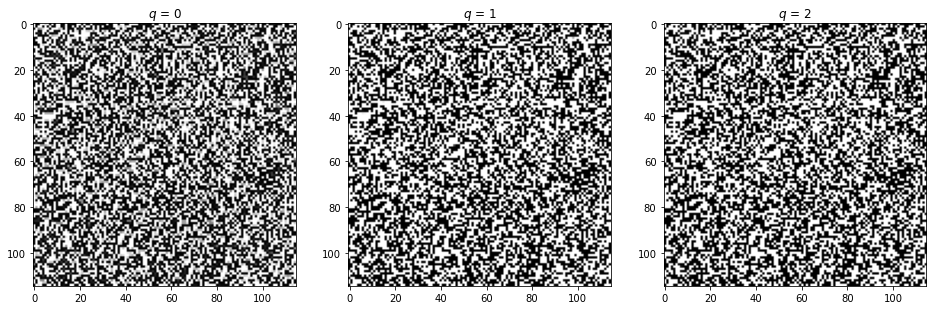

In [15]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,16))
ax1.imshow(sharp_images[0],cmap='gray')
ax1.title.set_text(rf"$q$ = {q_values[0]}")
ax2.imshow(sharp_images[1],cmap='gray')
ax2.title.set_text(rf"$q$ = {q_values[1]}")
ax3.imshow(sharp_images[2],cmap='gray')
ax3.title.set_text(rf"$q$ = {q_values[2]}")
plt.show()

**ABSOLUTE DIFFERENCE**

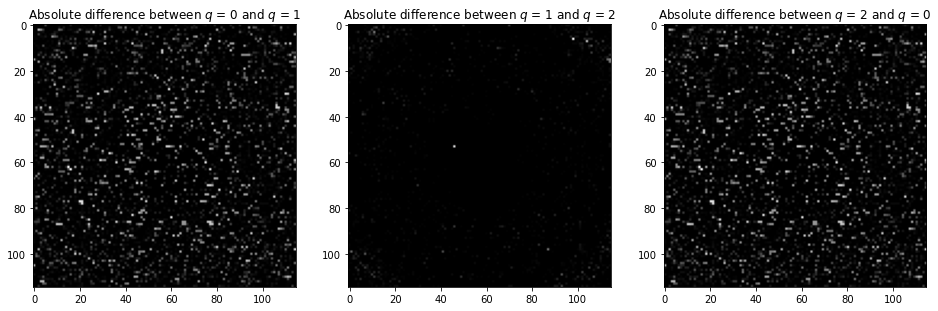

In [16]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,16))
ax1.imshow(np.abs(sharp_images[0]-sharp_images[1]),cmap='gray')
ax1.title.set_text(rf"Absolute difference between $q$ = {q_values[0]} and $q$ = {q_values[1]}")
ax2.imshow(np.abs(sharp_images[1]-sharp_images[2]),cmap='gray')
ax2.title.set_text(rf"Absolute difference between $q$ = {q_values[1]} and $q$ = {q_values[2]}")
ax3.imshow(np.abs(sharp_images[2]-sharp_images[0]),cmap='gray')
ax3.title.set_text(rf"Absolute difference between $q$ = {q_values[2]} and $q$ = {q_values[0]}")
plt.show()

**3D PLOTS FOR q = 0**

/var/folders/6g/kp6g8f296vz0ccdjvmzzmxn00000gn/T/ipykernel_64162/2759990183.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection = '3d')


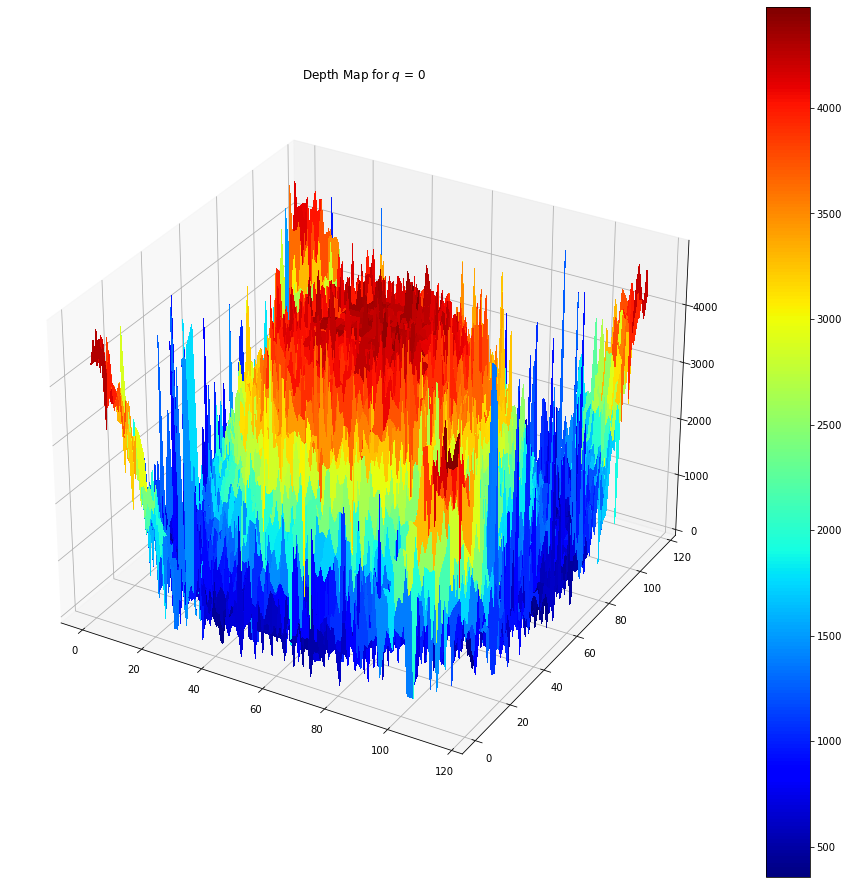

In [17]:
plotting(0)

**3D PLOTS FOR q = 1**

/var/folders/6g/kp6g8f296vz0ccdjvmzzmxn00000gn/T/ipykernel_64162/2759990183.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection = '3d')


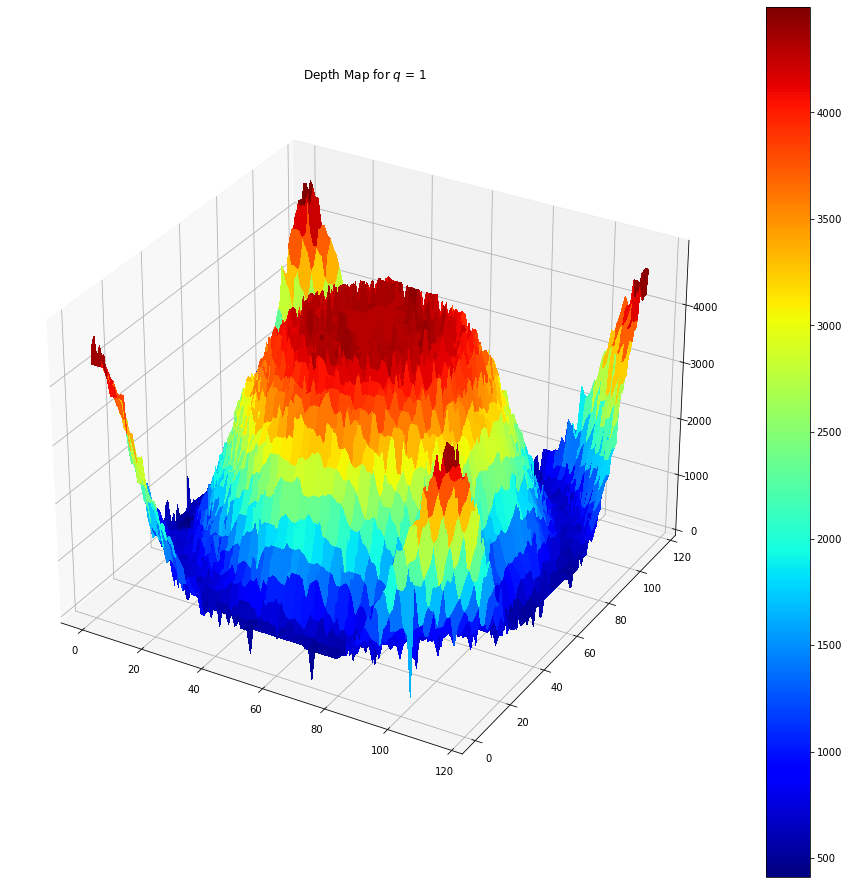

In [18]:
plotting(1)

**3D PLOTS FOR q = 2**

/var/folders/6g/kp6g8f296vz0ccdjvmzzmxn00000gn/T/ipykernel_64162/2759990183.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection = '3d')


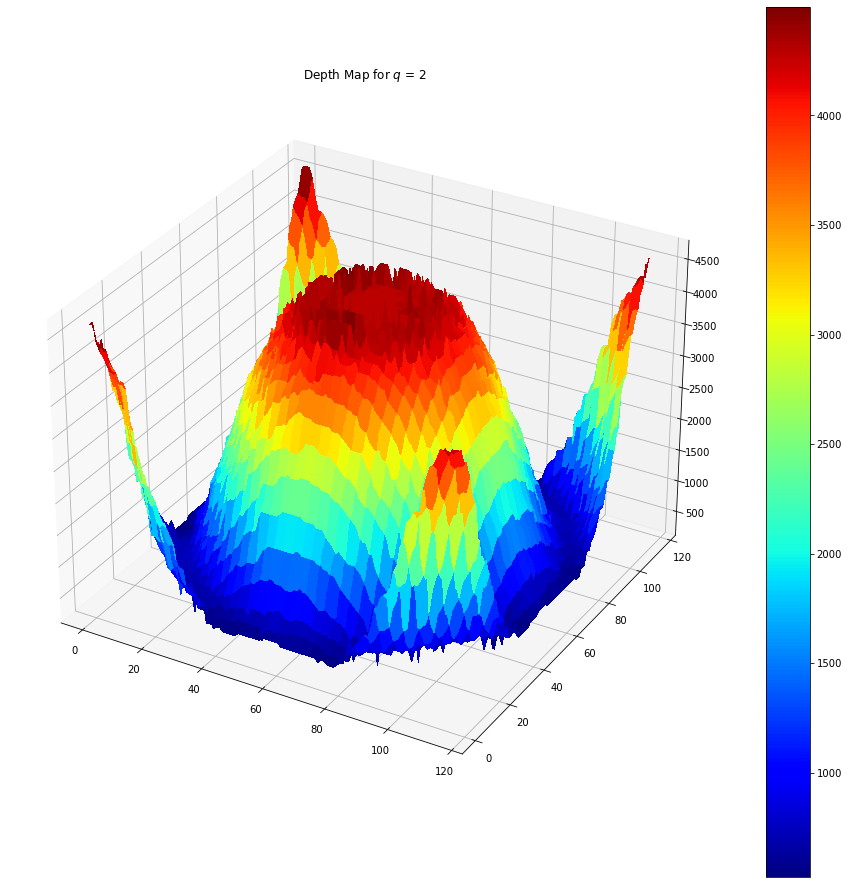

In [19]:
plotting(2)

# OBSERVATIONS:

The following observations can be made :
* The depth estimates are noticeably different
* As q increases we get smoother estimates
* We can observe that the image has a lot of texture provided the sharp image estimates look good
* Using larger q is more robust but it can merge depth information for nearby pixels